## **Задача оттока: варианты постановки, возможные способы решения**



1.   Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2.   Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3.  Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности



In [7]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Загрузка данных

In [2]:
df = pd.read_csv("/content/drive/MyDrive/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Распределение классов

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Разделение данных на train и test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

Построение pipeline

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

# OneHotEncoding для преобразования категориальных признаков
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]      

# Логарифмирование денежных признаков
class LogTransform(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log(X + 1)

Списки признаков

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'NumOfProducts']
money_columns = ['Balance', 'EstimatedSalary']

Создание трансформеров для признаков и объединение их в список

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('std', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
for mon_col in money_columns:
    mon_transformer = Pipeline([
                ('selector', NumberSelector(key=mon_col)),
                ('log', LogTransform()),
                ('std', StandardScaler())
            ])
    final_transformers.append((mon_col, mon_transformer))

In [9]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

**Использование модели случайного леса**

In [10]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])
pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.360000, F-Score=0.640, Precision=0.637, Recall=0.642


Поиск оптимальных параметров по сетке

In [15]:
%%time
params={'classifier__n_estimators':[100, 150, 200, 250, 300],
        'classifier__min_samples_leaf':[2, 3]
        }
cv = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=cv,
                    refit=False,
                   scoring='f1')

search = grid.fit(X_train, y_train)
print(search.best_params_)

{'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 150}
CPU times: user 1min 29s, sys: 280 ms, total: 1min 30s
Wall time: 1min 29s


Обучение модели

In [16]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42, min_samples_leaf=2, n_estimators=150)),
])
pipeline.fit(X_train, y_train)
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.393845, F-Score=0.655, Precision=0.704, Recall=0.613


**Использование модели градиентного бустинга**



In [17]:
pipeline2 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])
pipeline2.fit(X_train, y_train)
preds = pipeline2.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Поиск оптимальных параметров по сетке

In [18]:
%%time
params={'classifier__n_estimators':[100, 200, 300],
        'classifier__min_samples_leaf':[3, 4, 5]
        }
cv = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
grid = GridSearchCV(pipeline2,
                    param_grid=params,
                    cv=cv,
                    refit=False,
                   scoring='f1')

search = grid.fit(X_train, y_train)
print(search.best_params_)

{'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 300}
CPU times: user 1min 56s, sys: 149 ms, total: 1min 56s
Wall time: 1min 55s


Обучение модели

In [19]:
pipeline2 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42, min_samples_leaf=4, n_estimators=300)),
])
pipeline2.fit(X_train, y_train)
preds = pipeline2.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.405611, F-Score=0.647, Precision=0.687, Recall=0.611


**Использование модели логистической регрессии**

In [20]:
pipeline3 = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])
pipeline3.fit(X_train, y_train)
preds = pipeline3.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.257348, F-Score=0.502, Precision=0.421, Recall=0.623


**Вывод:** Наиболее высокое значение метрики F1-score наблюдается при использовании модели RandomForestClassifier.

Матрица ошибок

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1860  131]
 [ 198  311]]


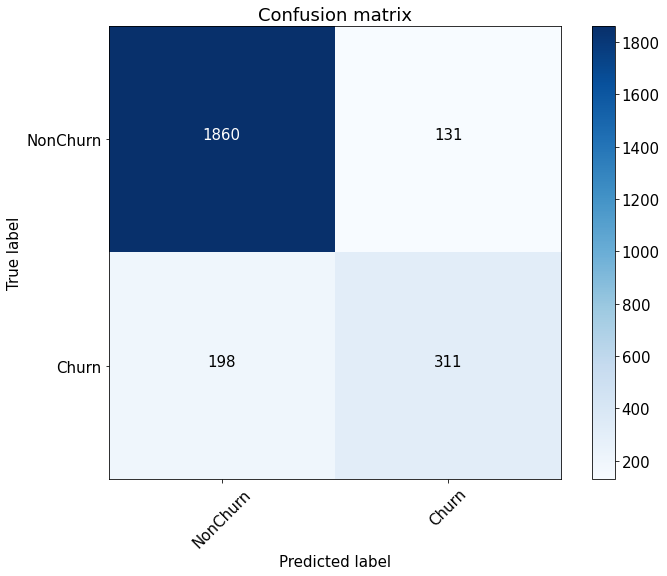

In [22]:
preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision[:-10] * recall[:-10]) / (precision[:-10] + recall[:-10])
# locate the index of the largest f score
ix = np.argmax(fscore)

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

**Вывод:** На привлечние клиентов потратили (311 + 131)\*1 = 442 долларов. Выручка со всех удержанных клиентов составила 311\*2 = 622 долларов. Прибыль будет 180 долларов с каждого удержанного клиента